In [1]:
# import dependecies
import numpy as np 
import mne 
import torchvision
import torch 
import re
import warnings
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os 
from braindecode.datasets import TUH
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, scale as multiply)
from braindecode.datasets.base import BaseDataset, BaseConcatDataset

from braindecode.util import set_random_seeds
from braindecode.models import Deep4Net
from braindecode.models import ShallowFBCSPNet

from torch.utils.data import WeightedRandomSampler

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split, SliceDataset
from torch.utils.data import DataLoader

from braindecode import EEGRegressor
from braindecode.training.losses import CroppedLoss
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
import torch
from torch.nn import HuberLoss

from sklearn.metrics import mean_absolute_error
from braindecode.training import trial_preds_from_window_preds

import pingouin as pg
from pingouin import ttest

mne.set_log_level('ERROR') 

In [3]:
class TUH(BaseConcatDataset):

    def __init__(self, path, recording_ids=None, target_name=None,
                 preload=False, add_physician_reports=False, n_jobs=1):
        file_paths = glob.glob(os.path.join(path, '**/*.edf'), recursive=True)
        descriptions = _create_description(file_paths)
        descriptions = _sort_chronologically(descriptions)
        
        if recording_ids is not None:
            if not isinstance(recording_ids, Iterable):
                recording_ids = range(recording_ids)
            descriptions = descriptions[recording_ids]
        
        if n_jobs == 1:
            base_datasets = [self._create_dataset(
                descriptions[i], target_name, preload, add_physician_reports)
                for i in descriptions.columns]
        else:
            base_datasets = Parallel(n_jobs)(delayed(
                self._create_dataset)(
                descriptions[i], target_name, preload, add_physician_reports
            ) for i in descriptions.columns)
        super().__init__(base_datasets)

    @staticmethod
    def _create_dataset(description, target_name, preload,
                        add_physician_reports):
        file_path = description.loc['path']

        
        age, gender = _parse_age_and_gender_from_edf_header(file_path)
        raw = mne.io.read_raw_edf(file_path, preload=preload)

        meas_date = datetime(1, 1, 1, tzinfo=timezone.utc) \
            if raw.info['meas_date'] is None else raw.info['meas_date']
        if 'year' in description:
            meas_date = meas_date.replace(
                *description[['year', 'month', 'day']])
        raw.set_meas_date(meas_date)

        d = {
            'age': int(age),
            'gender': gender,
        }
        
        if 'year' not in description:
            d['year'] = raw.info['meas_date'].year
            d['month'] = raw.info['meas_date'].month
            d['day'] = raw.info['meas_date'].day

        if add_physician_reports:
            physician_report = _read_physician_report(file_path)
            d['report'] = physician_report
        additional_description = pd.Series(d)
        description = pd.concat([description, additional_description])
        base_dataset = BaseDataset(raw, description,
                                   target_name=target_name)
        return base_dataset

def _create_description(file_paths):
    descriptions = [_parse_description_from_file_path(f) for f in file_paths]
    descriptions = pd.DataFrame(descriptions)
    return descriptions.T

def _sort_chronologically(descriptions):
    descriptions.sort_values(
        ["year", "month", "day", "subject", "session", "segment"],
        axis=1, inplace=True)
    return descriptions

def _read_date(file_path):
    date_path = file_path.replace('.edf', '_date.txt')
    # if date file exists, read it
    if os.path.exists(date_path):
        description = pd.read_json(date_path, typ='series').to_dict()
    # otherwise read edf file, extract date and store to file
    else:
        raw = mne.io.read_raw_edf(file_path, preload=False, verbose='error')
        description = {
            'year': raw.info['meas_date'].year,
            'month': raw.info['meas_date'].month,
            'day': raw.info['meas_date'].day,
        }
        try:
            pd.Series(description).to_json(date_path)
        except OSError:
            warnings.warn(f'Cannot save date file to {date_path}. '
                          f'This might slow down creation of the dataset.')
    return description


def _parse_description_from_file_path(file_path):
    
    file_path = os.path.normpath(file_path)
    tokens = file_path.split(os.sep)
    if ('train' in tokens) or ('eval' in tokens):  # tuh_eeg_abnormal
        abnormal = True
         
        if tokens[-2].split('_')[0][0] == 's':  # s denoting session number
            version = tokens[-9]  # Before dec 2022 updata
        else:
            version = tokens[-6]  # After the dec 2022 update
    
     
        subject_id = tokens[-1].split('_')[0]
        session = tokens[-1].split('_')[1]
        segment = tokens[-1].split('_')[2].split('.')[0]
        description = _read_date(file_path)
        description.update({
            'path': file_path,
            'version': version,
            'subject': subject_id,
            'session': int(session[1:]),
            'segment': int(segment[1:]),
        })
        if not abnormal:
            year, month, day = tokens[-3].split('_')[1:]
            description['year'] = int(year)
            description['month'] = int(month)
            description['day'] = int(day)
        return description

def _read_edf_header(file_path):
    f = open(file_path, "rb")
    header = f.read(88)
    f.close()
    return header

def _parse_age_and_gender_from_edf_header(file_path):
    header = _read_edf_header(file_path)
    patient_id = header[8:].decode("ascii")
    age = -1
    found_age = re.findall(r"Age:(\d+)", patient_id)
    if len(found_age) == 1:
        age = int(found_age[0])
    gender = "X"
    found_gender = re.findall(r"\s([F|M])\s", patient_id)
    if len(found_gender) == 1:
        gender = found_gender[0]
    return age, gender

In [4]:
class TUHAbnormal(TUH):
    
    def __init__(self, path, recording_ids=None, target_name='age',
                 preload=False, add_physician_reports=False, n_jobs=1, min_age = 20, max_age = 80):
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore", message=".*not in description. '__getitem__'")
            super().__init__(path=path, recording_ids=recording_ids,
                             preload=preload, target_name=target_name,
                             add_physician_reports=add_physician_reports,
                             n_jobs=n_jobs)
        
        additional_descriptions = []
        for file_path in self.description.path:
            additional_description = (
                self._parse_additional_description_from_file_path(file_path))
            additional_descriptions.append(additional_description)
        additional_descriptions = pd.DataFrame(additional_descriptions)
        self.set_description(additional_descriptions, overwrite=True)

    @staticmethod
    def _parse_additional_description_from_file_path(file_path):
        file_path = os.path.normpath(file_path)
        tokens = file_path.split(os.sep)
        
        if tokens[-2].split('_')[0][0] == 's':  
            version = tokens[-9]  
        else:
            version = tokens[-6]
            
        assert ('abnormal' in tokens or 'normal' in tokens), (
            'No pathology labels found.')
        assert ('train' in tokens or 'eval' in tokens), (
            'No train or eval set information found.')
        return {
            'version': version,
            'train': 'train' in tokens,
            'pathological': 'abnormal' in tokens,
        }

In [5]:
# train - normal EEG

TUH_PATH = 'TUH_abnormal/edf/train/normal'
N_JOBS = 1
tuh_train = TUHAbnormal(
    path=TUH_PATH,
    recording_ids=None,
    target_name='age',
    preload=False,
    add_physician_reports=False,
)

# test - evaluation set normal EEG

TUH_PATH = 'TUH_abnormal/edf/eval/normal'
N_JOBS = 1
tuh_eval_normal = TUHAbnormal(
    path=TUH_PATH,
    recording_ids=None,
    target_name='age',
    preload=False,
    add_physician_reports=False,
)

# test - evaluation set abnormal EEG

TUH_PATH = 'TUH_abnormal/edf/eval/abnormal'
N_JOBS = 1
tuh_eval_abnormal = TUHAbnormal(
    path=TUH_PATH,
    recording_ids=None,
    target_name='age',
    preload=False,
    add_physician_reports=False,
)

In [11]:
# check how many samples are in the dataset (duration(s) x sampling rate (250Hz))

print(len(tuh_train))
print(len(tuh_eval_normal))
print(len(tuh_eval_abnormal))

466200684
49930572
42777066


Visualisation - Age Distribution across the normal/abnormal EEGs (both train and evaluation sets)

Text(0, 0.5, 'Count')

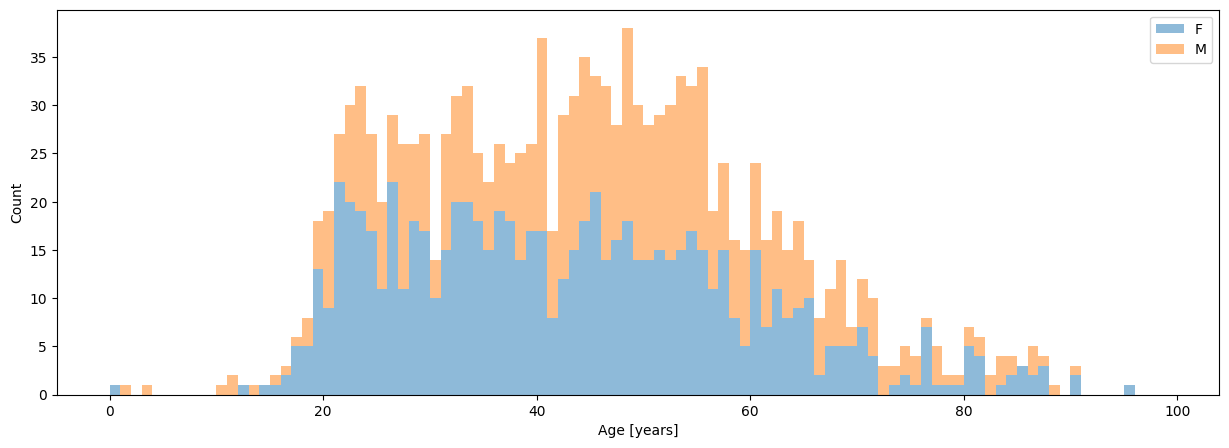

In [12]:
# TRAIN SET

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
genders = tuh_train.description.gender.unique()
x = [tuh_train.description.age[tuh_train.description.gender == g] for g in genders]
ax.hist(
    x=x,
    stacked=True,
    bins=np.arange(100, dtype=int),
    alpha=.5,
)
ax.legend(genders)
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

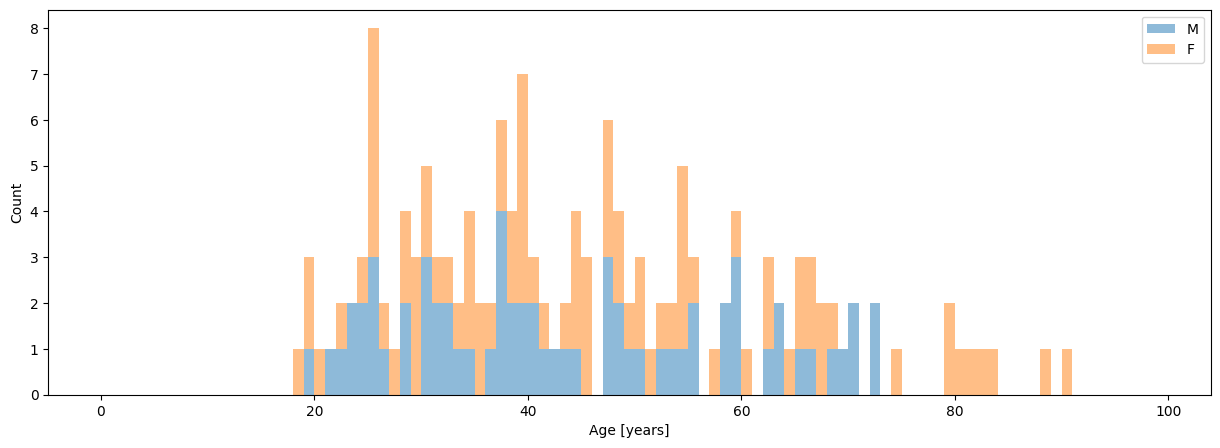

In [13]:
# EVALUATION SET - NORMAL 

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
genders = tuh_eval_normal.description.gender.unique()
x = [tuh_eval_normal.description.age[tuh_eval_normal.description.gender == g] for g in genders]
ax.hist(
    x=x,
    stacked=True,
    bins=np.arange(100, dtype=int),
    alpha=.5,
)
ax.legend(genders)
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

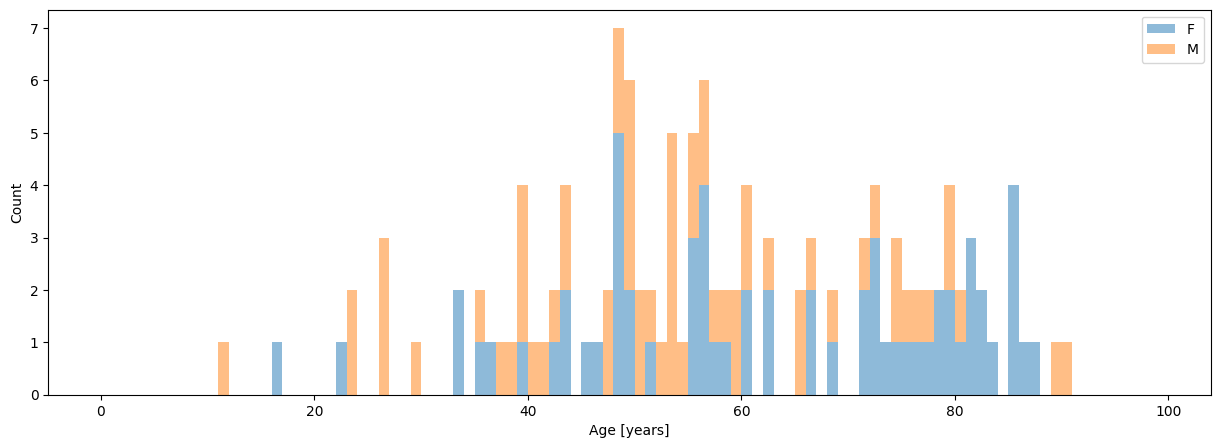

In [14]:
# EVAL - ABNORMAL 

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
genders = tuh_eval_abnormal.description.gender.unique()
x = [tuh_eval_abnormal.description.age[tuh_eval_abnormal.description.gender == g] for g in genders]
ax.hist(
    x=x,
    stacked=True,
    bins=np.arange(100, dtype=int),
    alpha=.5,
)
ax.legend(genders)
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')


Preprocessing

In [15]:
short_ch_names = sorted([
    'A1', 'A2',
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ'])
ar_ch_names = sorted([
    'EEG A1-REF', 'EEG A2-REF',
    'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
    'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
    'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
    'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'])

assert len(short_ch_names) == len(ar_ch_names) 
ar_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    ar_ch_names, short_ch_names)}

ch_mapping = {'ar': ar_ch_mapping}

def custom_rename_channels(raw, mapping):

    reference = raw.ch_names[0].split('-')[-1].lower()
    assert reference in ['le', 'ref'], 'unexpected referencing'
    reference = 'le' if reference == 'le' else 'ar'
    raw.rename_channels(mapping[reference])
    
def select_by_channels(ds, ch_mapping):
    split_ids = []
    for i, d in enumerate(ds.datasets):
        ref = 'ar' 
        
        seta = set(ch_mapping[ref].keys())
        
        setb = set(d.raw.ch_names)
        
        if seta.issubset(setb):
            split_ids.append(i)
    return ds.split(split_ids)['0']

tuh_train = select_by_channels(tuh_train, ch_mapping)
tuh_eval_normal = select_by_channels(tuh_eval_normal, ch_mapping)
tuh_eval_abnormal = select_by_channels(tuh_eval_abnormal, ch_mapping)

In [16]:
def filter_samples_by_age(dataset, min_age, max_age):
    age_mask = (dataset.description['age'] >= min_age) & (dataset.description['age'] <= max_age)
    return dataset.split(np.where(age_mask)[0])['0']

tuh_train = filter_samples_by_age(tuh_train, min_age=20, max_age=80)
tuh_eval_normal = filter_samples_by_age(tuh_eval_normal, min_age=20, max_age=80)
tuh_eval_abnormal = filter_samples_by_age(tuh_eval_abnormal, min_age=20, max_age=80)

In [17]:
def custom_crop(raw, discard_first = 60, tmin=0.0, tmax=None, include_tmax=True):
    samples_to_discard = int(discard_first * raw.info['sfreq'])
    tmax = min((raw.n_times - 1) / raw.info['sfreq'], tmax)
    raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)

# discard first 60s of every recording 
discard_first = 60
# keep recordings that have a min 60s 
tmin = discard_first
# max recording - 1200s (15 min)
tmax = 15 * 60
# downsample sampling rate to from 250Hz to 100Hz 
sfreq = 100

preprocessors = [
    # crop recrodings  
    Preprocessor(custom_crop, tmin=tmin, tmax=tmax, include_tmax=False,
                 apply_on_array=False),
    Preprocessor(custom_rename_channels, mapping=ch_mapping,
                 apply_on_array=False),
    # keep only 21 channels from 36
    Preprocessor('pick_channels', ch_names=short_ch_names, ordered=True),
    Preprocessor(np.clip, a_min=-800, a_max=800, apply_on_array=True),
    Preprocessor('resample', sfreq=sfreq),
]

In [18]:
tuh_preproc_train = preprocess(
    concat_ds=tuh_train,
    preprocessors=preprocessors,
    n_jobs=N_JOBS,
)

In [19]:
tuh_preproc_eval_normal = preprocess(
    concat_ds=tuh_eval_normal,
    preprocessors=preprocessors,
    n_jobs=N_JOBS,
)

In [20]:
tuh_preproc_eval_abnormal = preprocess(
    concat_ds=tuh_eval_abnormal,
    preprocessors=preprocessors,
    n_jobs=N_JOBS,
)

In [21]:
#  check number of samples in the dataset after preprocessing 
print(len(tuh_preproc_train))
print(len(tuh_preproc_eval_normal))
print(len(tuh_preproc_eval_abnormal))

108528000
11844000
9240000


Create epochs/windows

In [23]:
window_size_samples = 750 # 7.5s epocs 
window_stride_samples = 750

tuh_windows_train = create_fixed_length_windows(tuh_preproc_train,
                                              start_offset_samples=0,
                                              stop_offset_samples=0,
                                              window_size_samples=window_size_samples,
                                              window_stride_samples=window_stride_samples,
                                              drop_last_window=False,
                                              n_jobs = N_JOBS,
                                               )
tuh_windows_train.set_description({
    "n_windows_train": [len(d) for d in tuh_windows_train.datasets]})

/rds/general/user/rim22/home/anaconda3/envs/projectTUH/lib/python3.11/site-packages/braindecode/preprocessing/windowers.py:602: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  warnings.warn(


In [24]:
window_size_samples = 750 # 7.5s epocs 
window_stride_samples = 750

tuh_windows_eval_normal = create_fixed_length_windows(tuh_preproc_eval_normal,
                                              start_offset_samples=0,
                                              stop_offset_samples=0,
                                              window_size_samples=window_size_samples,
                                              window_stride_samples=window_stride_samples,
                                              drop_last_window=False,
                                              n_jobs = N_JOBS,
                                               )
tuh_windows_eval_normal.set_description({
    "n_windows_train": [len(d) for d in tuh_windows_eval_normal.datasets]})

/rds/general/user/rim22/home/anaconda3/envs/projectTUH/lib/python3.11/site-packages/braindecode/preprocessing/windowers.py:602: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  warnings.warn(


In [25]:
window_size_samples = 750 # 7.5s epocs 
window_stride_samples = 750

tuh_windows_eval_abnormal = create_fixed_length_windows(tuh_preproc_eval_abnormal,
                                              start_offset_samples=0,
                                              stop_offset_samples=0,
                                              window_size_samples=window_size_samples,
                                              window_stride_samples=window_stride_samples,
                                              drop_last_window=False,
                                              n_jobs = N_JOBS,
                                               )
tuh_windows_eval_abnormal.set_description({
    "n_windows_train": [len(d) for d in tuh_windows_eval_abnormal.datasets]})

/rds/general/user/rim22/home/anaconda3/envs/projectTUH/lib/python3.11/site-packages/braindecode/preprocessing/windowers.py:602: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  warnings.warn(


In [26]:
print(len(tuh_windows_train))
print(len(tuh_windows_eval_normal))
print(len(tuh_windows_eval_abnormal))

144704
15792
12320


Model Training

In [28]:
# no weighted random sampler 

In [29]:
metadata = tuh_windows_eval_normal.get_metadata()
labels = metadata.target

In [31]:
labels

0      23
1      23
2      23
3      23
4      23
       ..
107    66
108    66
109    66
110    66
111    66
Name: target, Length: 15792, dtype: int64

In [32]:
ages_list = [ds.description.age for ds in tuh_windows_train.datasets]
ages = np.array(ages_list)

In [33]:
bins = np.arange(20, 85, 5) 
bins

array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])

In [34]:
labels = [f'{start}-{start+5}' for start in bins[:-1]]
labels

['20-25',
 '25-30',
 '30-35',
 '35-40',
 '40-45',
 '45-50',
 '50-55',
 '55-60',
 '60-65',
 '65-70',
 '70-75',
 '75-80']

In [35]:
age_groups = pd.cut(ages, bins=bins, labels=labels, right=False, ordered = True)
age_groups 

['35-40', '20-25', '60-65', '60-65', '45-50', ..., '25-30', '65-70', '40-45', '55-60', '20-25']
Length: 1292
Categories (12, object): ['20-25' < '25-30' < '30-35' < '35-40' ... '60-65' < '65-70' < '70-75' < '75-80']

In [ ]:
class_frequencies = age_groups.value_counts().sort_index()
class_weights = 1 / class_frequencies

In [ ]:
class_weights /= class_weights.sum()  # normalise weights (sum should be = 1)
class_weights

In [ ]:
class_weights_tensor = torch.from_numpy(class_weights.values)
class_weights_tensor

In [ ]:
sampler = WeightedRandomSampler(class_weights_tensor, len(class_weights_tensor), replacement=True)
sampler

In [ ]:
# split training data into train and validation sets - for calibration 

In [33]:
X_train = SliceDataset(tuh_windows_train, idx=0)
y_train = np.array([y for y in SliceDataset(tuh_windows_train, idx=1)])
train_indices, val_indices = train_test_split(
    X_train.indices_, test_size=0.2, shuffle=False
)
train_subset = Subset(tuh_windows_train, train_indices)
val_subset = Subset(tuh_windows_train, val_indices)

In [60]:
print(len(X_train))
print(len(y_train))

36176
36176


In [37]:
print(len(train_subset))
print(len(val_subset))

28940
7236


In [36]:
n_chans = 21
n_classes = 1
input_window_samples = 750

In [37]:
from braindecode.models.util import to_dense_prediction_model, get_output_shape

model_name = "shallow"  # 'shallow' or 'deep'

if model_name in ["shallow", "Shallow", "ShallowConvNet"]:
    model = ShallowFBCSPNet(in_chans=n_chans,
                            n_classes=n_classes,
                            input_window_samples=input_window_samples,
                            n_filters_time=40, n_filters_spat=40,
                            final_conv_length=35,
                            
                            )
elif model_name in ["deep", "Deep", "DeepConvNet"]:
    model = Deep4Net(in_chans=n_chans, n_classes=n_classes,
                     input_window_samples=input_window_samples,
                     n_filters_time=25, n_filters_spat=25,
                     stride_before_pool=True,
                     n_filters_2=n_chans * 2,
                     n_filters_3=n_chans * 4,
                     n_filters_4=n_chans * 8,
                     final_conv_length=1,
                     
                     )
else:
    raise ValueError(f'{model_name} unknown')

new_model = torch.nn.Sequential()
for name, module_ in model.named_children():
    if "softmax" in name:
        continue
    new_model.add_module(name, module_)
model = new_model

to_dense_prediction_model(model)
n_preds_per_input = get_output_shape(model, n_chans, window_size_samples)[
    2]

In [38]:
print(model)

Sequential(
  (ensuredims): Ensure4d()
  (dimshuffle): Expression(expression=transpose_time_to_spat) 
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 21), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin_exp): Expression(expression=square) 
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(1, 1), padding=0)
  (pool_nonlin_exp): Expression(expression=safe_log) 
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(40, 1, kernel_size=(35, 1), stride=(1, 1), dilation=(15, 1))
  (squeeze): Expression(expression=squeeze_final_output) 
)


In [39]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True


seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)
if cuda:
    model.cuda()

/rds/general/user/rim22/home/anaconda3/envs/projectTUH/lib/python3.11/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


In [ ]:
train_loader = DataLoader(tuh_windows_train, batch_size=batch_size, sampler = sampler)
test_loader = DataLoader(tuh_windows_eval_normal, batch_size=batch_size, shuffle = False)

In [ ]:
y_train = tuh_windows_train.get_metadata().target

In [ ]:
weights = []
for i in range(len(bins)):
    # Define the age range for this bin
    age_start = bins[i]
    age_end = bins[i + 1] if i < len(bins) - 1 else 80

    # Get indices corresponding to this age bin
    indices_in_bin = np.where((y_train >= age_start) & (y_train < age_end))[0]

    # Calculate the weight for this age bin
    weight = len(indices_in_bin) / len(y_train)

    # Add the weight to the list
    weights.extend([weight] * len(indices_in_bin))

# Create a tensor of weights
weights = torch.tensor(weights, dtype=torch.float32)

In [37]:
scaling_factor = 112.5

class ScaledHuberLoss(HuberLoss):
    def forward(self, input, target):
        loss = super().forward(input, target)
        return loss / scaling_factor

batch_size = 64
n_epochs = 25
optimizer_lr = 0.001
optimizer_weight_decay = 0

regressor = EEGRegressor(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=ScaledHuberLoss(reduction='mean', delta=5.0),
    optimizer=torch.optim.Adam,
    optimizer__lr=optimizer_lr,
    optimizer__weight_decay=optimizer_weight_decay,
    train_split=None,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "neg_root_mean_squared_error",
        "neg_mean_absolute_error",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))
    ],
    device=device,
)

regressor.fit(tuh_windows_train, y=None, epochs=n_epochs)

  epoch    train_loss    train_neg_mean_absolute_error    train_neg_root_mean_squared_error      lr       dur
-------  ------------  -------------------------------  -----------------------------------  ------  --------
      1        0.3982                         -51.4062                             -53.4006  0.0010  104.8845
      2        0.3458                         -59.0947                             -60.8376  0.0010  113.8310
      3        0.3219                         -42.0924                             -44.5059  0.0010  109.1224
      4        0.3102                         -24.0957                             -28.1187  0.0010  108.1790
      5        0.3002                         -23.0029                             -27.1285  0.0009  105.4105
      6        0.2936                         -40.1932                             -42.7146  0.0009  104.8445
      7        0.2864                         -19.5164                             -23.7895  0.0009  104.8269
      8   

In [40]:
scaling_factor = 112.5

class ScaledHuberLoss(HuberLoss):
    def forward(self, input, target):
        loss = super().forward(input, target)
        return loss / scaling_factor

batch_size = 64
n_epochs = 25
optimizer_lr = 0.001
optimizer_weight_decay = 0

regressor = EEGRegressor(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=ScaledHuberLoss(reduction='mean', delta=5.0),
    optimizer=torch.optim.Adam,
    optimizer__lr=optimizer_lr,
    optimizer__weight_decay=optimizer_weight_decay,
    train_split=None,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "neg_root_mean_squared_error",
        "neg_mean_absolute_error",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))
    ],
    device=device,
)

regressor.fit(tuh_windows_train, y=None, epochs=n_epochs)

  epoch    train_loss    train_neg_mean_absolute_error    train_neg_root_mean_squared_error      lr       dur
-------  ------------  -------------------------------  -----------------------------------  ------  --------
      1        0.4111                         -33.8487                             -36.8064  0.0010  111.0631
      2        0.3629                         -18.5733                             -22.8009  0.0010  99.6317
      3        0.3336                         -60.7627                             -62.4579  0.0010  99.6636
      4        0.3200                         -34.3941                             -37.3082  0.0010  99.3591
      5        0.3105                         -12.8646                             -15.5125  0.0009  99.5748
      6        0.3035                         -34.9890                             -37.8616  0.0009  99.6123
      7        0.2978                        -104.8021                            -105.8291  0.0009  104.7228
      8        

EVAL NORMAL 

In [49]:
y_test_normal = np.array(tuh_windows_eval_normal.get_metadata().target)
y_pred_normal = np.array(regressor.predict(tuh_windows_eval_normal))

In [50]:
len(y_pred_normal) # predictions for individual windows 

15792

In [52]:
# predictions per window - NORMAL
mae = mean_absolute_error(y_test_normal, y_pred_normal)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 8.47


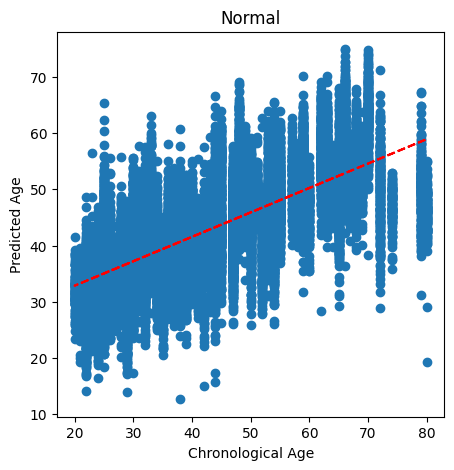

In [53]:
# window with 7.5s (normal)

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
y_estim = np.ravel(regressor.predict(tuh_windows_eval_normal))
y_gt = tuh_windows_eval_normal.get_metadata()["target"].to_numpy()

_ = axes.scatter(y_gt, y_estim)
_ = axes.set_title("Normal")
_ = axes.set_ylabel("Predicted Age")
_ = axes.set_xlabel("Chronological Age")

z = np.polyfit(y_gt, y_estim, 1)
p = np.poly1d(z)
plt.plot(y_gt, p(y_gt), "r--")
plt.show()

In [54]:
# predictions  per trial - aggregate windows (112 windows per trial) - NORMAL SET
pred_win_normal = regressor.predict_with_window_inds_and_ys(tuh_windows_eval_normal)

In [56]:
pred_win_normal

{'preds': array([[[32.16727 , 32.24775 , 32.301727, ..., 32.267796, 32.351864,
          32.42263 ]],
 
        [[31.811817, 31.777906, 31.795189, ..., 33.930008, 33.97353 ,
          33.984615]],
 
        [[30.199623, 30.184803, 30.186321, ..., 33.713806, 33.693058,
          33.69715 ]],
 
        ...,
 
        [[72.17229 , 72.35478 , 72.391106, ..., 68.18204 , 68.171814,
          68.078606]],
 
        [[51.565113, 51.44975 , 51.406124, ..., 56.573467, 56.504135,
          56.437447]],
 
        [[57.07561 , 57.07081 , 57.15801 , ..., 60.53375 , 60.326283,
          60.11901 ]]], dtype=float32),
 'i_window_in_trials': array([  0,   1,   2, ..., 109, 110, 111]),
 'i_window_stops': array([ 6750,  7500,  8250, ..., 88500, 89250, 90000]),
 'window_ys': array([23, 23, 23, ..., 66, 66, 66])}

In [57]:
preds_per_trial_normal= trial_preds_from_window_preds(pred_win_normal['preds'], pred_win_normal['i_window_in_trials'], pred_win_normal['i_window_stops'])
mean_preds_per_trial_normal = [np.mean(preds, axis=1) for preds in
                                preds_per_trial_normal]
mean_preds_per_trial_normal = np.array(mean_preds_per_trial_normal)

In [59]:
# test normal (per session) and pred normal (per session)
y_test_normal_trial = np.array(tuh_eval_normal.description.age)
# calc MAE (per session) 
mae_normal_trial = mean_absolute_error(y_test_normal_trial, mean_preds_per_trial_normal)
print(f"Mean Absolute Error: {mae_normal_trial:.2f}")

Mean Absolute Error: 7.55


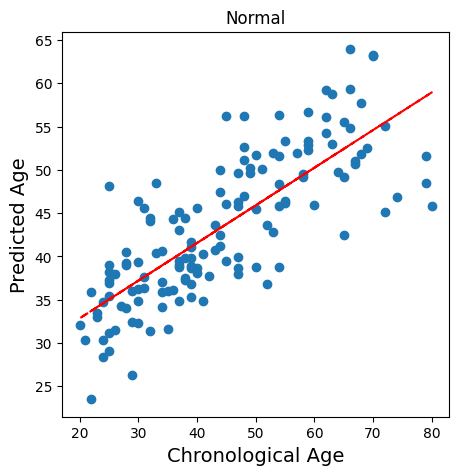

In [60]:
# trial - NORMAL SET

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
y_estim = np.ravel(mean_preds_per_trial_normal)
y_gt = tuh_eval_normal.description.age.to_numpy()

_ = axes.scatter(y_gt, y_estim)
_ = axes.set_title("Normal")
_ = axes.set_ylabel("Predicted Age", fontsize=14) 
_ = axes.set_xlabel("Chronological Age", fontsize=14)

z = np.polyfit(y_gt, y_estim, 1)
p = np.poly1d(z)
plt.plot(y_gt, p(y_gt), "r--")
plt.show()

EVAL ABNORMAL

In [61]:
# predictions per window (7.5s) - ABNORMAL 
y_test_abnormal = np.array(tuh_windows_eval_abnormal.get_metadata().target)
y_pred_abnormal = np.array(regressor.predict(tuh_windows_eval_abnormal))

In [62]:
# MAE (windows) - ABNORMAL 
mae = mean_absolute_error(y_test_abnormal, y_pred_abnormal)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 14.04


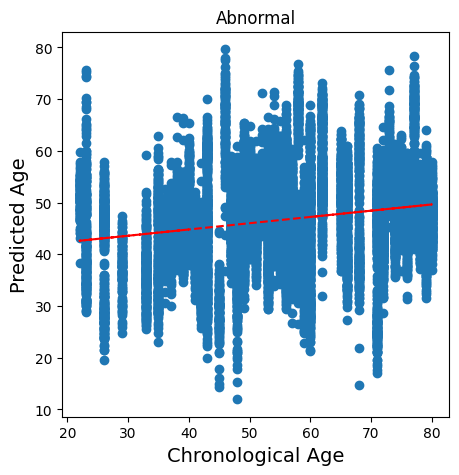

In [64]:
# with 7.5s (windows) - ABNORMAL

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
y_estim_ab = np.ravel(regressor.predict(tuh_windows_eval_abnormal))
y_gt_ab = tuh_windows_eval_abnormal.get_metadata()["target"].to_numpy()

_ = axes.scatter(y_gt_ab, y_estim_ab)
_ = axes.set_title("Abnormal")
_ = axes.set_ylabel("Predicted Age", fontsize=14) 
_ = axes.set_xlabel("Chronological Age", fontsize=14)

z = np.polyfit(y_gt_ab, y_estim_ab, 1)
p = np.poly1d(z)
plt.plot(y_gt_ab, p(y_gt_ab), "r--")
plt.show()

In [65]:
# trial predictions - ABNORMAL 
pred_win_abnormal = regressor.predict_with_window_inds_and_ys(tuh_windows_eval_abnormal)

In [66]:
pred_win_abnormal

{'preds': array([[[39.588287, 39.530586, 39.492683, ..., 37.95609 , 37.825012,
          37.72838 ]],
 
        [[37.472015, 37.52912 , 37.616047, ..., 37.975285, 37.97001 ,
          38.032444]],
 
        [[44.362682, 44.377403, 44.371292, ..., 48.298843, 48.290462,
          48.283524]],
 
        ...,
 
        [[37.96299 , 38.139473, 38.3186  , ..., 39.140312, 39.219196,
          39.162704]],
 
        [[57.94931 , 58.03228 , 58.121185, ..., 55.06235 , 55.138027,
          55.225025]],
 
        [[49.84436 , 49.857292, 49.913067, ..., 48.770435, 48.706482,
          48.68624 ]]], dtype=float32),
 'i_window_in_trials': array([  0,   1,   2, ..., 109, 110, 111]),
 'i_window_stops': array([ 6750,  7500,  8250, ..., 88500, 89250, 90000]),
 'window_ys': array([60, 60, 60, ..., 40, 40, 40])}

In [67]:
preds_per_trial_abnormal= trial_preds_from_window_preds(pred_win_abnormal['preds'], pred_win_abnormal['i_window_in_trials'], pred_win_abnormal['i_window_stops'])
mean_preds_per_trial_abnormal = [np.mean(preds, axis=1) for preds in
                                preds_per_trial_abnormal]
mean_preds_per_trial_abnormal = np.array(mean_preds_per_trial_abnormal)

In [69]:
# test abnormal (per session) and pred abnormal (per session)
y_test_abnormal_trial = np.array(tuh_eval_abnormal.description.age)
# calc MAE (per session) - ABNORMAL
mae_abnormal_trial = mean_absolute_error(y_test_abnormal_trial, mean_preds_per_trial_abnormal)
print(f"Mean Absolute Error: {mae_abnormal_trial:.2f}")

Mean Absolute Error: 13.41


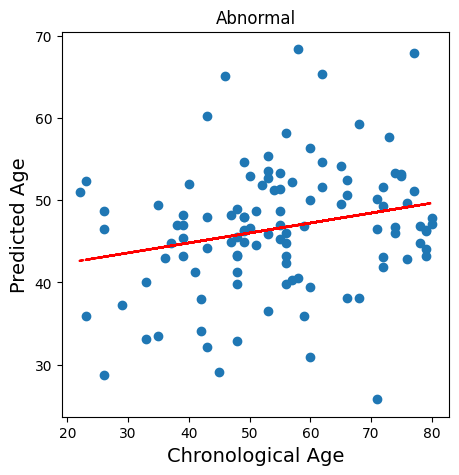

In [71]:
# trial - ABNORMAL SET

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
y_estim = np.ravel(mean_preds_per_trial_abnormal)
y_gt = tuh_eval_abnormal.description.age.to_numpy()

_ = axes.scatter(y_gt, y_estim)
_ = axes.set_title("Abnormal")
_ = axes.set_ylabel("Predicted Age", fontsize=14) 
_ = axes.set_xlabel("Chronological Age", fontsize=14)

z = np.polyfit(y_gt, y_estim, 1)
p = np.poly1d(z)
plt.plot(y_gt, p(y_gt), "r--")
plt.show()

In [63]:
bins #age bins 

array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])

In [72]:
# pred per bin - NORMAL 
predictions_by_age_bin_normal = {}

for i in range(len(bins)):
    #  age range for this bin
    age_start = bins[i]
    age_end = bins[i + 1] if i < len(bins) - 1 else 80
    indices_in_bin_normal = np.where((y_test_normal_trial >= age_start) & (y_test_normal_trial < age_end))[0]
    predictions_in_bin_normal = mean_preds_per_trial_normal[indices_in_bin_normal]
    predictions_by_age_bin_normal[f"{age_start}-{age_end}"] = predictions_in_bin_normal

for age_range, predictions_normal in predictions_by_age_bin_normal.items():
    print(f"Age Range {age_range}: Predictions = {predictions_normal}")

Age Range 20-25: Predictions = [[33.504436]
 [23.49686 ]
 [35.93438 ]
 [34.728794]
 [32.082623]
 [30.328848]
 [28.326761]
 [32.971638]
 [30.358974]]
Age Range 25-30: Predictions = [[39.234447]
 [26.251179]
 [35.9942  ]
 [39.008724]
 [40.526314]
 [38.98359 ]
 [36.94088 ]
 [29.09011 ]
 [37.265472]
 [48.087345]
 [35.446835]
 [32.39747 ]
 [31.201088]
 [38.18423 ]
 [34.017403]
 [37.917637]
 [34.2449  ]
 [31.526676]]
Age Range 30-35: Predictions = [[45.62625 ]
 [46.37037 ]
 [32.358498]
 [40.601215]
 [37.569527]
 [48.511368]
 [36.3848  ]
 [44.089985]
 [37.002506]
 [31.426485]
 [39.356762]
 [36.255833]
 [40.435936]
 [34.205647]
 [34.857426]
 [35.92171 ]
 [44.381153]]
Age Range 35-40: Predictions = [[38.651905]
 [38.87342 ]
 [39.056145]
 [38.804276]
 [44.47901 ]
 [37.544674]
 [41.638794]
 [39.50716 ]
 [36.05591 ]
 [36.848293]
 [35.31157 ]
 [45.09386 ]
 [44.289593]
 [39.79958 ]
 [39.83235 ]
 [41.037605]
 [31.65994 ]
 [36.08003 ]
 [43.045563]
 [34.872154]
 [37.278576]]
Age Range 40-45: Prediction

/rds/general/user/rim22/home/anaconda3/envs/projectTUH/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/rim22/home/anaconda3/envs/projectTUH/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/rds/general/user/rim22/home/anaconda3/envs/projectTUH/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/rim22/home/anaconda3/envs/projectTUH/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/rim22/home/anaconda3/envs/projectTUH/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered i

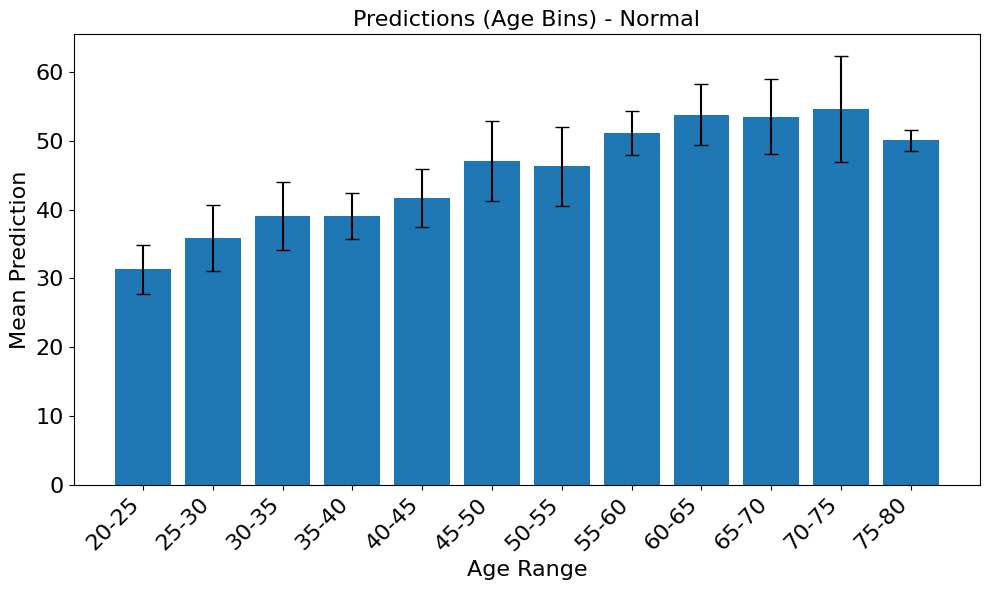

In [84]:
age_ranges = list(predictions_by_age_bin_normal.keys())
predictions_normal = list(predictions_by_age_bin_normal.values())

# Plotting the bar chart - normal
plt.figure(figsize=(10, 6))
plt.bar(age_ranges, [np.mean(pred) for pred in predictions_normal], yerr=[np.std(pred) for pred in predictions_normal], capsize=5)
plt.xlabel('Age Range', fontsize=16)
plt.ylabel('Mean Prediction', fontsize=16)
plt.title('Predictions (Age Bins) - Normal', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=16)  # Set the font size for x-axis labels
plt.yticks(fontsize=16)  # Set the font size for y-axis labels
plt.tight_layout()
plt.show()

In [77]:
mae_per_bin_normal = {}

for age_range, predictions_normal in predictions_by_age_bin_normal.items():
    indices_in_bin_normal = np.where((y_test_normal_trial >= int(age_range.split('-')[0])) & (y_test_normal_trial < int(age_range.split('-')[1])))[0]
    
    if len(indices_in_bin_normal) > 0 and len(predictions_normal) > 0:
        true_ages_bin = y_test_normal_trial[indices_in_bin_normal]
        mae_bin_normal = mean_absolute_error(true_ages_bin, predictions_normal)
        mae_per_bin_normal[age_range] = mae_bin_normal
    else:
        mae_per_bin_normal[age_range] = np.nan

for age_range, mae_value_normal in mae_per_bin_normal.items():
    print(f"Age Range {age_range}: MAE = {mae_value_normal:.4f}")

Age Range 20-25: MAE = 8.7481
Age Range 25-30: MAE = 9.6565
Age Range 30-35: MAE = 7.3825
Age Range 35-40: MAE = 2.6990
Age Range 40-45: MAE = 3.0609
Age Range 45-50: MAE = 4.3799
Age Range 50-55: MAE = 6.6868
Age Range 55-60: MAE = 6.2259
Age Range 60-65: MAE = 8.4370
Age Range 65-70: MAE = 13.0203
Age Range 70-75: MAE = 16.9191
Age Range 75-80: MAE = 28.9171
Age Range 80-80: MAE = nan


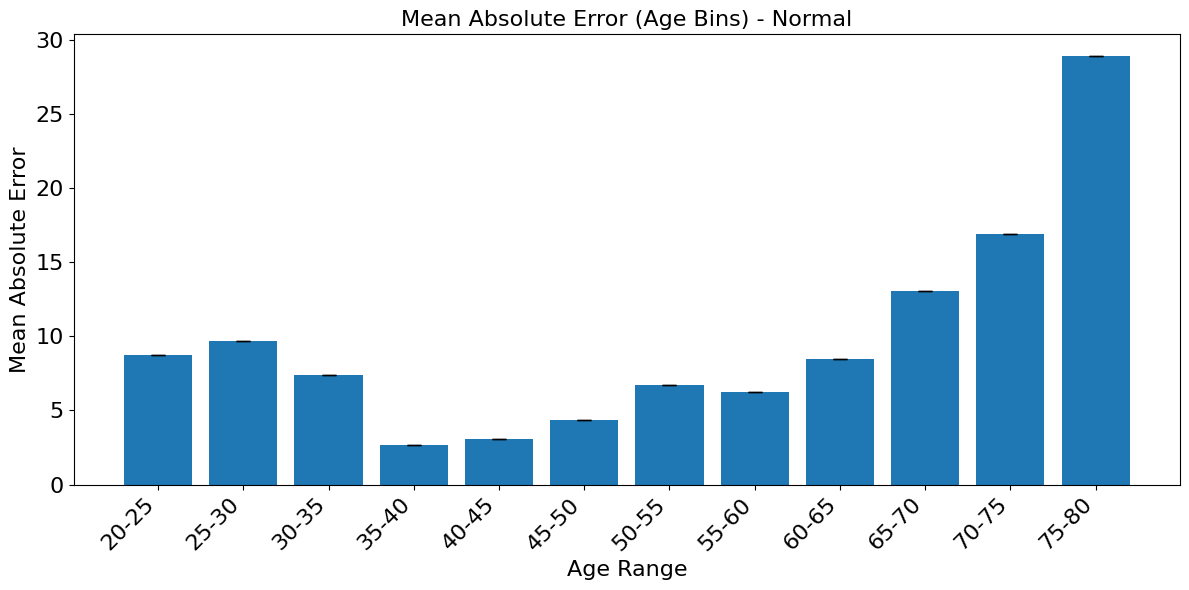

In [85]:
mae_df_normal = pd.DataFrame(list(mae_per_bin_normal.items()), columns=['Age Range', 'MAE'])

plt.figure(figsize=(12, 6))
plt.bar(mae_df_normal['Age Range'], mae_df_normal['MAE'], yerr=np.zeros_like(mae_df_normal['MAE']), capsize=5)
plt.title('Mean Absolute Error (Age Bins) - Normal', fontsize=16)
plt.xlabel('Age Range', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [86]:
# pred per bin - ABNORMAL 
predictions_by_age_bin_abnormal = {}

for i in range(len(bins)):
    #  age range for this bin
    age_start = bins[i]
    age_end = bins[i + 1] if i < len(bins) - 1 else 80
    indices_in_bin_abnormal = np.where((y_test_abnormal_trial >= age_start) & (y_test_abnormal_trial < age_end))[0]
    predictions_in_bin_abnormal = mean_preds_per_trial_abnormal[indices_in_bin_abnormal]
    predictions_by_age_bin_abnormal[f"{age_start}-{age_end}"] = predictions_in_bin_abnormal

for age_range, predictions_abnormal in predictions_by_age_bin_abnormal.items():
    print(f"Age Range {age_range}: Predictions = {predictions_abnormal}")

Age Range 20-25: Predictions = [[35.89502 ]
 [51.006535]
 [52.383453]]
Age Range 25-30: Predictions = [[37.29039 ]
 [46.46963 ]
 [48.719147]
 [28.714365]]
Age Range 30-35: Predictions = [[33.174618]
 [40.11199 ]]
Age Range 35-40: Predictions = [[33.49434 ]
 [45.374634]
 [44.78518 ]
 [49.464413]
 [47.004803]
 [46.978355]
 [43.007507]
 [43.246517]
 [48.169674]]
Age Range 40-45: Predictions = [[41.26033 ]
 [44.140594]
 [34.042435]
 [38.018745]
 [47.983505]
 [60.21689 ]
 [32.161476]
 [51.963318]]
Age Range 45-50: Predictions = [[48.176136]
 [43.346752]
 [48.974693]
 [45.532578]
 [54.664974]
 [32.94076 ]
 [39.81254 ]
 [44.96272 ]
 [65.069115]
 [46.393696]
 [47.98061 ]
 [43.242966]
 [47.917725]
 [46.304413]
 [29.153862]
 [41.22412 ]
 [44.872406]]
Age Range 50-55: Predictions = [[51.196182]
 [51.807476]
 [55.363125]
 [45.845345]
 [53.58953 ]
 [48.744568]
 [36.567295]
 [44.597363]
 [52.718334]
 [52.895695]
 [46.64918 ]]
Age Range 55-60: Predictions = [[68.353226]
 [51.32993 ]
 [47.004063]
 [52

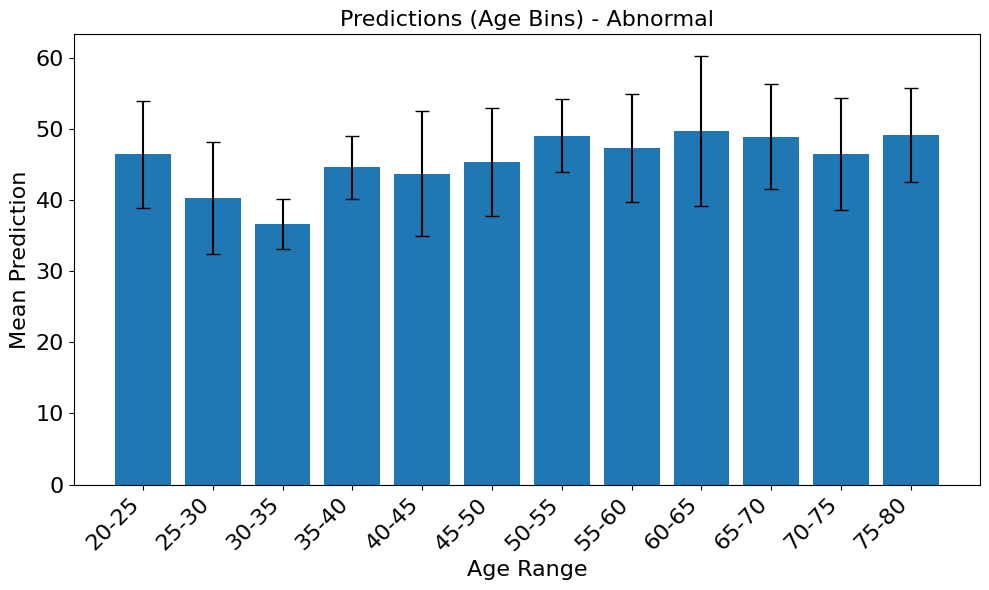

In [87]:
age_ranges = list(predictions_by_age_bin_abnormal.keys())
predictions_abnormal = list(predictions_by_age_bin_abnormal.values())

plt.figure(figsize=(10, 6))
plt.bar(age_ranges, [np.mean(pred) for pred in predictions_abnormal], yerr=[np.std(pred) for pred in predictions_abnormal], capsize=5)
plt.xlabel('Age Range', fontsize=16)
plt.ylabel('Mean Prediction', fontsize=16)
plt.title('Predictions (Age Bins) - Abnormal', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [88]:
mae_per_bin_abnormal = {}

for age_range, predictions_abnormal in predictions_by_age_bin_abnormal.items():
    indices_in_bin_abnormal = np.where((y_test_abnormal_trial >= int(age_range.split('-')[0])) & (y_test_abnormal_trial < int(age_range.split('-')[1])))[0]
    
    if len(indices_in_bin_abnormal) > 0 and len(predictions_abnormal) > 0:
        true_ages_bin_abnormal = y_test_abnormal_trial[indices_in_bin_abnormal]
        mae_bin_abnormal = mean_absolute_error(true_ages_bin_abnormal, predictions_abnormal)
        mae_per_bin_abnormal[age_range] = mae_bin_abnormal
    else:
        mae_per_bin_abnormal[age_range] = np.nan

for age_range, mae_value_abnormal in mae_per_bin_abnormal.items():
    print(f"Age Range {age_range}: MAE = {mae_value_abnormal:.4f}")

Age Range 20-25: MAE = 23.7617
Age Range 25-30: MAE = 13.5484
Age Range 30-35: MAE = 3.6433
Age Range 35-40: MAE = 7.5041
Age Range 40-45: MAE = 7.2927
Age Range 45-50: MAE = 5.7765
Age Range 50-55: MAE = 4.0657
Age Range 55-60: MAE = 10.5927
Age Range 60-65: MAE = 12.0659
Age Range 65-70: MAE = 17.3557
Age Range 70-75: MAE = 25.8296
Age Range 75-80: MAE = 28.2238
Age Range 80-80: MAE = nan


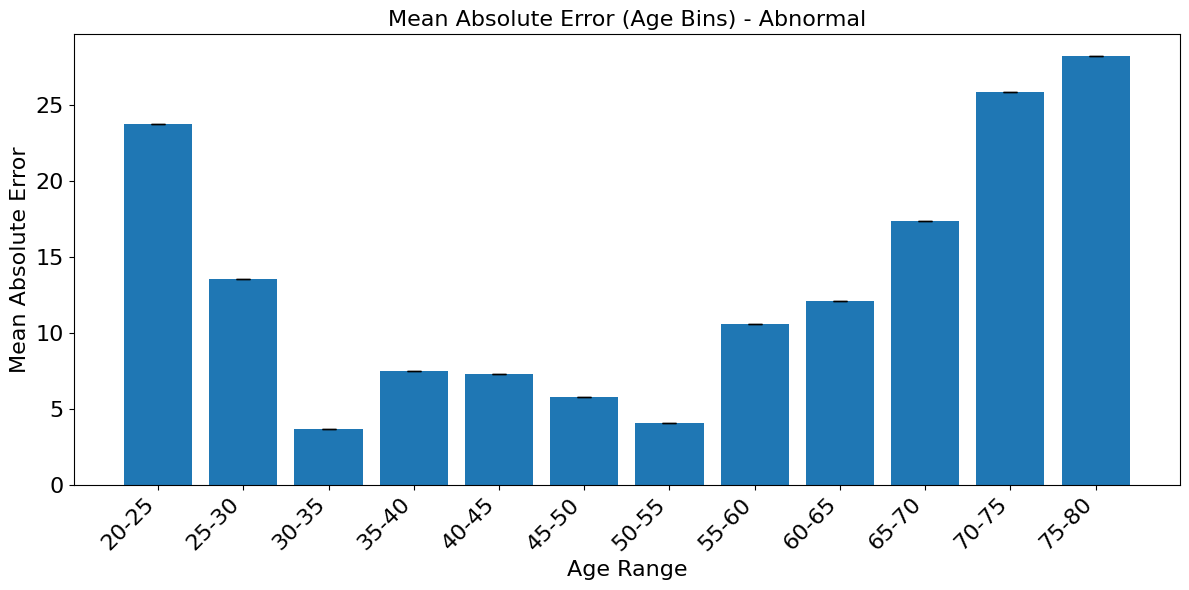

In [89]:
mae_df_abnormal = pd.DataFrame(list(mae_per_bin_abnormal.items()), columns=['Age Range', 'MAE'])

plt.figure(figsize=(12, 6))
plt.bar(mae_df_abnormal['Age Range'], mae_df_abnormal['MAE'], yerr=np.zeros_like(mae_df_abnormal['MAE']), capsize=5)
plt.title('Mean Absolute Error (Age Bins) - Abnormal', fontsize=16)
plt.xlabel('Age Range', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=16)
plt.xticks(rotation=45, ha='right',fontsize=16 )  
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

--------------------------

In [81]:
import ml_insights as mli

In [179]:
from sklearn.calibration import calibration_curve

In [343]:
#  weighted average MAE - normal 
total_samples = len(y_test_normal)
weighted_mae_normal = 0
total_weight = 0

mae_per_bin_abnormal = {}  # Dictionary to store MAE for each bin

for i, age_range in enumerate(age_ranges):
    # get indices corresponding to this age bin
    indices_in_bin = np.where((y_test_normal >= int(age_range.split('-')[0])) & (y_test_normal < int(age_range.split('-')[1])))[0]

    if len(indices_in_bin) > 0:
        # Calculate MAE only if there are samples in the age bin
        mae_bin = mean_absolute_error(y_test_normal[indices_in_bin], predictions[i])
        weight = 1 / mae_bin if mae_bin > 0 else 0  # use  weight (avoid division by zero)
        weighted_mae_normal += mae_bin * weight
        total_weight += weight

        mae_per_bin_normal[age_range] = mae_bin

# MAE for each bin
for age_range, mae in mae_per_bin_normal.items():
    print(f"MAE for Age Range {age_range}: {mae}")

if total_weight > 0:
    weighted_mae_normal /= total_weight

print(f"Weighted Average MAE (Normal): {weighted_mae_normal}")

MAE for Age Range 20-25: 7.183232375553676
MAE for Age Range 25-30: 8.002917842259484
MAE for Age Range 30-35: 6.933590299942914
MAE for Age Range 35-40: 4.671637509144893
MAE for Age Range 40-45: 5.2089719488507225
MAE for Age Range 45-50: 5.699994459606352
MAE for Age Range 50-55: 7.348494975121467
MAE for Age Range 55-60: 5.917688982827323
MAE for Age Range 60-65: 7.777960446416115
MAE for Age Range 65-70: 12.463356538252397
MAE for Age Range 70-75: 15.564208357674735
MAE for Age Range 75-80: 27.94985921042306
Weighted Average MAE (Normal): 7.482393016389128


BRAIN AGE 

In [116]:
x = mean_preds_per_trial_abnormal.flatten()
y = mean_preds_per_trial_normal.flatten()

In [129]:
delta_abnormal_0.mean()

-7.777134479175914

In [128]:
delta_normal_0.mean()

-0.7403918868261026

In [119]:
delta_abnormal_0  = (x - y_test_abnormal_trial)
delta_normal_0 =  (y - y_test_normal_trial)

In [120]:
pg.ttest(delta_normal_0, delta_abnormal_0, paired=True, alternative='two-sided', correction='auto')

/rds/general/user/rim22/home/anaconda3/envs/projectTUH/lib/python3.11/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.337181,182.002877,two-sided,0.000024,"[3.84, 10.24]",0.578117,808.688,0.99487


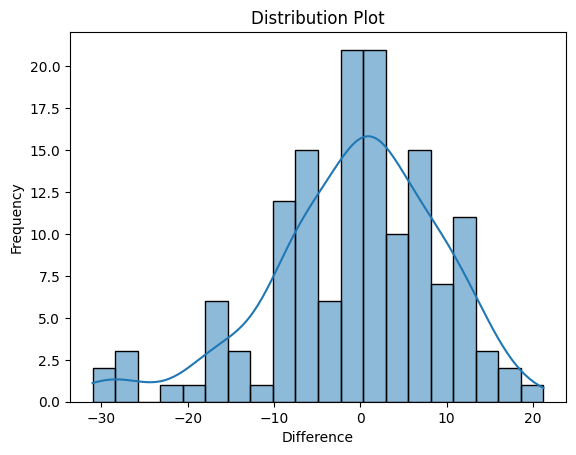

In [137]:
sns.histplot(delta_normal_0, bins=20, kde=True)
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.title("Distribution Plot")
plt.show()

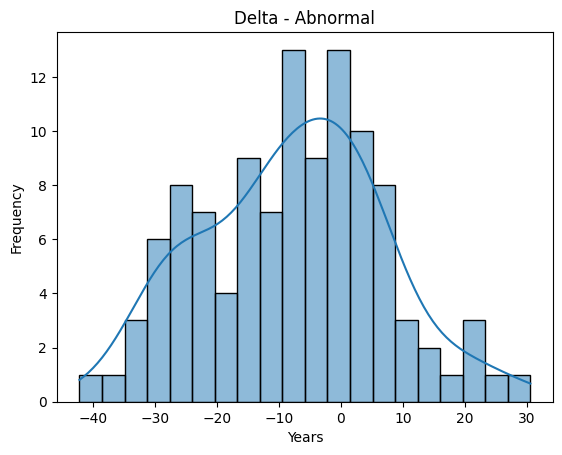

In [140]:
sns.histplot(delta_abnormal_0, bins=20, kde=True)
plt.xlabel("Years")
plt.ylabel("Frequency")
plt.title("Delta - Abnormal")
plt.show()